In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import accuracy_score, recall_score, f1_score,confusion_matrix

import event_classification

random.seed(2021)

### Import data

In [2]:
# IMPORT DATA

#import shower summary tables
#fn_ph = pd.read_csv("../shower_data/350shower/final_ph.csv",index_col=0)
#fn_pr = pd.read_csv("../shower_data/350shower/final_pr.csv",index_col=0)

In [20]:
# DATA TABLE CREATION

#join them
#all_ph = fn_ph.append(fn_pr)
#all_ph.reset_index(drop=True, inplace=True)
all_ph = pd.read_csv("../shower_data/combined_all_1600.csv")


# log10 to dt, E, and counts
#all_ph[["dt"]]=all_ph["dt"].apply(np.log10)
#all_ph[["E"]]=all_ph["E"].apply(np.log10)
#all_ph[["dxy"]]=all_ph["dxy"].apply(np.log10)
#all_ph[["muon_detector_array"]]=all_ph["muon_detector_array"].apply(lambda x : np.log10(x+1))
#all_ph[["em_scintillator_array"]]=all_ph["em_scintillator_array"].apply(lambda x : np.log10(x+1))

all_ph.head(5)

,dt,dxy,em_scintillator_array,muon_detector_array,origin
0,1.591065,3.736556,2.891537,0.477121,1
1,1.612784,3.971415,2.670246,0.301030,1
2,1.579784,3.890365,2.818226,0.000000,1
3,1.414973,3.749195,2.684845,0.301030,1
4,1.462398,3.839855,2.964260,0.602060,1


## Using 2 Main features : counts per shower in each type of detector

In [21]:
#all feautres
x_data =  all_ph[["muon_detector_array","em_scintillator_array"]].values

#WARNING 2D visualization of classification impossible on more than 2 features
#x_data =  all_ph[["muon_detector_array","em_scintillator_array","dt","dxy"]].values 
#target
y_data = np.array([0 if d ==1 else 1 for d in all_ph["origin"].values])#.reshape(-1,1)



### Model: construction and training

In [22]:
# classifier
clf  = event_classification.Logistic_probability_threshold(cv=10) #cross-val with cv k-folds

In [23]:
# train the model
clf.fit_model(x_data,y_data,test_s=0.1)

The best threshold is in 0.308 where 0.0% of PS are misclassified and 0.0% of GS are miscalssified
Optimal threshold set at 0.308


### Model: performance

In [24]:
# evalaute
clf.evaluate(x_data,y_data)

0.125% of proton showers are misclassified and 4.75% of gamma showers are miscalssified
Total accuracy 97.5625%
F1 score 0.9762


[0.975625, 0.9761759315821625, 0.00125, 0.0475]

### Pseudo-empiric logistic formula for classification

The classification probability is the result of feeding the X-features into a logistic formula that uses some coefficient to weight the features in a lineal combination. The resultant probability is the result of:

$$ P(X) = \frac{1}{1 + e^{-(c_0  + x_1\cdot c_1 + x_2\cdot c_2 + x_3\cdot c_3+x_4\cdot c_4)}}$$

where $c_0$ is the intercept value and the other $c_i$ correspont each one to the weight of certain feature in X (we are using 4 features at most, but usually 2 of them are certainly available). After that, the selection rule with the threshold $\tau$ is applied:

* $Y_{pred} = 0$ if $P(X) \lt \tau$ classifying the event as a gamma shower (GS)

* $Y_{pred} = 1$ if $P(X) \ge \tau$ classifying the event as a proton shower (PS)

In fact, we can obtain the coeficients $c_i$ and the threshold $\tau$ from the classifier object after trained. Using this coeficients in a formula for classification is equivalent to use the whole regression model object to predict.

In [25]:
# obtaining the coeficients in an list in the format [tau, c0, c1, c2]
clf.give_coefs()

[0.308, -2.3415833426957025, 3.430183368145208, -0.5683387849875519]

In [26]:
def classify_with_formula(X,coefs):
    ans = []
    for x in X:
        # logistic equation
        reg = coefs[1] + np.sum([coefs[i+2]*x[i] for i in range(len(coefs)-2)])
        px = 1/(1+np.exp(-reg))
        # selection rule
        y = 1 if px>=coefs[0] else 0
        
        ans.append(y)
    
    return ans

In [27]:
#generate predictions using the formula and the coeficients found
y_pred = classify_with_formula(x_data,clf.give_coefs())
# accuracy value, equal to the one using clf.evaluate()
acc = np.sum(y_pred == y_data)/len(y_data)
acc

0.975625

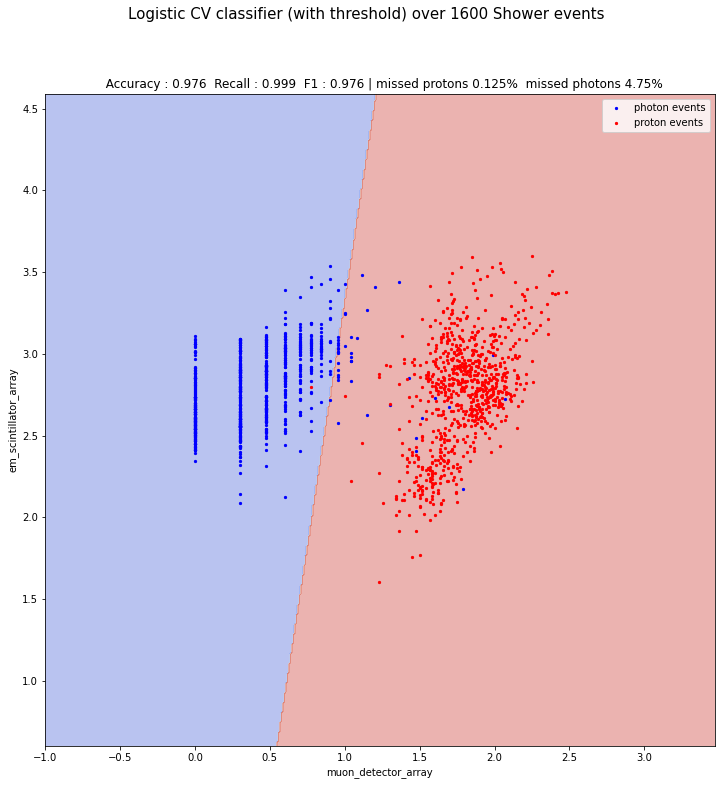

In [28]:
h = 0.01  # step size in the mesh
# create a mesh to plot in
x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#train-test sample splitting
#x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.3)


#building the classifier
#clf = svm.SVC(kernel="linear")  # RandomForestClassifier(n_estimators=20,oob_score=True))
#clf.fit(x_train, y_train)


#region classification
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)



y_pred = clf.predict(x_data)
tn, fp, fn, tp = confusion_matrix(y_data.reshape(-1),y_pred).ravel()
acc_i = round(accuracy_score(y_data,y_pred),3)
rec_i = round(recall_score(y_data,y_pred),3)
f1_i = round(f1_score(y_data,y_pred),3)
pr_pass = round(100*fn/(fn+tp),3) # 1 -recall
ph_pass = round(100*fp/(tn+fp),3) # 1 - specificity


plt.figure(figsize=(12,12))
plt.subplot(1,1,1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.contourf(xx,yy, Z, cmap=plt.cm.coolwarm, alpha=0.4)

plt.scatter(x_data[y_data==0][:,0],x_data[y_data==0][:,1], c="b",s=5,label="photon events")
plt.scatter(x_data[y_data==1][:,0],x_data[y_data==1][:,1], c="r",s=5,label="proton events")

plt.xlabel("muon_detector_array")
plt.ylabel("em_scintillator_array")

plt.suptitle("Logistic CV classifier (with threshold) over {} Shower events ".format(len(y_data)),fontsize=15)
plt.title("  Accuracy : {}  Recall : {}  F1 : {} | missed protons {}%  missed photons {}%".format(acc_i,rec_i,f1_i,pr_pass,ph_pass))

plt.legend()

## Using all features : including $\Delta$t and $\Delta$xy

### Model: construction and training

In [29]:
#all feautres
#x_data =  all_ph[["muon_detector_array","em_scintillator_array"]].values

#WARNING 2D visualization of classification impossible on more than 2 features
x_data =  all_ph[["muon_detector_array","em_scintillator_array","dt","dxy"]].values 
#target
y_data = np.array([0 if d ==1 else 1 for d in all_ph["origin"].values])#.reshape(-1,1)




# classifier
clf  = event_classification.Logistic_probability_threshold(cv=10) #cross-val with cv k-folds
# train the model
clf.fit_model(x_data,y_data,test_s=0.1)

The best threshold is in 0.106 where 0.0% of PS are misclassified and 1.333% of GS are miscalssified
Optimal threshold set at 0.10640000000000001


### Model: performance

In [30]:
# evalaute
clf.evaluate(x_data,y_data)

0.0% of proton showers are misclassified and 3.75% of gamma showers are miscalssified
Total accuracy 98.125%
F1 score 0.9816


[0.98125, 0.9815950920245399, 0.0, 0.0375]

### Pseudo-empiric logistic formula for classification

In [31]:
#generate predictions using the formula and the coeficients found
y_pred = classify_with_formula(x_data,clf.give_coefs())
# accuracy value, equal to the one using clf.evaluate()
acc = np.sum(y_pred == y_data)/len(y_data)
acc

0.98125

In [32]:
# obtaining the coeficients in an list in the format [tau, c0, c1, c2,c3,c4]
clf.give_coefs()

[0.10640000000000001,
 -8.187057797580408,
 4.779244273073689,
 -1.9873275633406493,
 1.7181771899839948,
 1.1680218795439603]

### Test size

In [16]:
test_sizes=[0,0.15,0.3]
vals2={}
vals4={}
#all feautres
x_data_2 =  all_ph[["muon_detector_array","em_scintillator_array"]].values

#WARNING 2D visualization of classification impossible on more than 2 features
x_data_4 =  all_ph[["muon_detector_array","em_scintillator_array","dt","dxy"]].values 
#target
y_data = np.array([0 if d ==1 else 1 for d in all_ph["origin"].values])#.reshape(-1,1)

for ts in test_sizes:
    
    # classifier
    clf_2 = event_classification.Logistic_probability_threshold(cv=15) #cross-val with cv k-folds
    # train the model
    clf_2.fit_model(x_data_2,y_data,test_s=ts)
    
    coefs_2 = clf_2.give_coefs()
    evals_2 = clf_2.evaluate(x_data_2,y_data)
    
    # classifier
    clf_4 = event_classification.Logistic_probability_threshold(cv=15) #cross-val with cv k-folds
    # train the model
    clf_4.fit_model(x_data_4,y_data,test_s=ts)
    
    coefs_4 = clf_4.give_coefs()
    evals_4 = clf_4.evaluate(x_data_4,y_data)
    
    vals2[ts] = coefs_2+evals_2
#    vals2[ts][["tau","c0","c1","c2"]] = coefs_2
#    vals2[ts][["acc","f1","PSerror","GSerror"]] = evals_2
    
    vals4[ts] =  coefs_4+evals_4

    
    
    
    

The best threshold is in 0.214 where 0.0% of PS are misclassified and 10.75% of GS are miscalssified
Optimal threshold set at 0.21380000000000002
0.0% of proton showers are misclassified and 10.75% of gamma showers are miscalssified
Total accuracy 94.625%
F1 score 0.949
The best threshold is in 0.428 where 0.0% of PS are misclassified and 1.375% of GS are miscalssified
Optimal threshold set at 0.42800000000000005
0.0% of proton showers are misclassified and 1.375% of gamma showers are miscalssified
Total accuracy 99.3125%
F1 score 0.9932
The best threshold is in 0.385 where 0.0% of PS are misclassified and 3.101% of GS are miscalssified
Optimal threshold set at 0.3854
0.125% of proton showers are misclassified and 2.75% of gamma showers are miscalssified
Total accuracy 98.5625%
F1 score 0.9858
The best threshold is in 0.319 where 0.0% of PS are misclassified and 1.695% of GS are miscalssified
Optimal threshold set at 0.31920000000000004
0.0% of proton showers are misclassified and 2.12

In [17]:
pd.DataFrame(vals2)

,0.00,0.15,0.30
0,0.213800,0.385400,0.480000
1,-2.376150,-2.299340,-1.103285
2,3.552025,3.366379,1.255171
3,-0.596310,-0.536045,-0.107115
4,0.946250,0.985625,0.989375
5,0.948992,0.985811,0.989461
6,0.000000,0.001250,0.002500
7,0.107500,0.027500,0.018750


In [18]:
pd.DataFrame(vals4)

,0.00,0.15,0.30
0,0.428000,0.319200,0.581000
1,-5.963092,-5.781823,-5.574101
2,2.961363,2.840936,2.644354
3,-0.826851,-0.726972,-0.655791
4,1.236187,1.180479,1.137012
5,0.600440,0.550575,0.524013
6,0.993125,0.989375,0.991250
7,0.993172,0.989487,0.991272
8,0.000000,0.000000,0.006250
9,0.013750,0.021250,0.011250
